In [1]:
import pandas as pd
import numpy as np
import pmdarima as pm
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
from statsmodels.tools.sm_exceptions import ValueWarning
import warnings

warnings.simplefilter('ignore')
np.random.seed(42)

## Preprocessing

In [2]:
df = pd.read_csv("data/mood_aggregated.csv")

# We only care about mood for ARIMA, so we drop other variables
df = df[df.variable == 'mood']

# We keep the id, timestamp, and value for mood
df = df[['id', 'time', 'value']]

# We change the time strings to datetime objjects
df.time = pd.to_datetime(df.time)
df.time = df.time.dt.floor('H')

# We rename the value column to mood since it only contains values for mood now
df = df.rename(columns={'value': 'mood'})

df = df.dropna()

## Separating the data
* First we will separate for each participant
* Then we will do a train/test split for each

In [3]:
# We split the data for each participant
participants = {participant: df[df.id == participant].drop(['id'], axis=1) for participant in df.id.unique()}

# Maps each participants to a train and test set
train_test_dict = {}
for participant in participants:
    train = list(participants[participant]['mood'])[:-1]
    test = list(participants[participant]['mood'])[-1]
    
    train_test_dict[participant] = {'train': train, 'test': test}


## Finding the models with the optimal parameters

In [4]:
# Maps each participant to a fitted model
model_dict = {}
for participant in participants:
    train = train_test_dict[participant]['train']
    
    model = pm.auto_arima(train, start_p=1, start_q=1,
                          test='adf',       # use adftest to find optimal 'd'
                          max_p=5, max_q=5, # maximum p and q
                          m=1,              # frequency of series
                          d=None,           # let model determine 'd'
                          seasonal=False,   # No Seasonality (Might have to check for this shit?)
                          start_P=0, 
                          D=0, 
                          trace=False,
                          error_action='ignore',  
                          suppress_warnings=True, 
                          stepwise=True)
    model_dict[participant] = model

## Using the statsmodels package ARIMA function

In [5]:
final_models = {}
fitted_models = {}
for participant in model_dict.keys():
    order = model_dict[participant].order
    endog = train_test_dict[participant]['train']
    model = ARIMA(endog=endog, order=order)
    
    final_models[participant] = model
    
    fitted_models[participant] = model.fit()

## Predicting with each model

In [6]:
prediction_dict = {}
for participant in participants:
    # Get the correct model
    model = fitted_models[participant]
    
    # Get the real labels and cutoff
    true_labels = [train_test_dict[participant]['test']]
    
    
    size = len(train_test_dict[participant]['train'])
    
    # Predict
    predictions = model.predict(start=size, end=size)
    
    assert len(predictions) == len(true_labels)
    
    # Save the predictions
    prediction_dict[participant] = {'true_labels': true_labels, 'predictions': predictions}

In [7]:
for participant in prediction_dict:
    true_value = prediction_dict[participant]['true_labels']
    prediction = prediction_dict[participant]['predictions']
    
    MAE = mean_absolute_error(true_value, prediction)
    MSE = mean_squared_error(true_value, prediction)
    
    print(f"{participant}     MAE = {MAE:.2f}     MSE = {MSE:.2f}     True_Value = {true_value[0]:.2f}       Predicted = {list(prediction)[0]:.2f}")

AS14.01     MAE = 0.22     MSE = 0.05     True_Value = 8.00       Predicted = 7.78
AS14.02     MAE = 2.89     MSE = 8.32     True_Value = 9.00       Predicted = 6.11
AS14.03     MAE = 0.29     MSE = 0.08     True_Value = 7.67       Predicted = 7.38
AS14.05     MAE = 0.58     MSE = 0.34     True_Value = 6.33       Predicted = 6.92
AS14.06     MAE = 0.19     MSE = 0.03     True_Value = 7.00       Predicted = 7.19
AS14.07     MAE = 0.39     MSE = 0.15     True_Value = 5.50       Predicted = 5.89
AS14.08     MAE = 0.08     MSE = 0.01     True_Value = 6.67       Predicted = 6.75
AS14.09     MAE = 1.14     MSE = 1.30     True_Value = 6.00       Predicted = 7.14
AS14.12     MAE = 0.01     MSE = 0.00     True_Value = 6.00       Predicted = 6.01
AS14.13     MAE = 0.23     MSE = 0.05     True_Value = 8.00       Predicted = 7.77
AS14.14     MAE = 0.13     MSE = 0.02     True_Value = 7.00       Predicted = 6.87
AS14.15     MAE = 0.05     MSE = 0.00     True_Value = 7.00       Predicted = 6.95
AS14

In [8]:
absolute = []
squared = []

for participant in prediction_dict:
    true_value = prediction_dict[participant]['true_labels']
    prediction = prediction_dict[participant]['predictions']
    
    MAE = mean_absolute_error(true_value, prediction)
    MSE = mean_squared_error(true_value, prediction)
    
    absolute.append(MAE)
    squared.append(MSE)    

## ARIMA for multiple days prediction

In [9]:
# Getting train and test data
train = pd.read_csv("data/train.csv", index_col=0)
test = pd.read_csv("data/test.csv", index_col=0)

# Train and test splits for each participant
splits = {}
for participant in train.id.unique():
    tr = train[train.id == participant]
    tr.index = range(len(tr))
    
    te = test[test.id == participant]
    te.index = range(len(tr), len(tr) + len(te))
    
    # Sexy
    assert tr.index[-1] == te.index[0] -1
    
    splits[participant] = {
        'train': tr,
        'test': te
    }


model_dict_multi = {}
for participant in splits:
    train = splits[participant]['train']['next_mood']
    
    model = pm.auto_arima(train, start_p=1, start_q=1,
                          test='adf',       # use adftest to find optimal 'd'
                          max_p=5, max_q=5, # maximum p and q
                          m=1,              # frequency of series
                          d=None,           # let model determine 'd'
                          seasonal=False,   # No Seasonality (Might have to check for this shit?)
                          start_P=0, 
                          D=0, 
                          trace=False,
                          error_action='ignore',  
                          suppress_warnings=True, 
                          stepwise=True)
    model_dict_multi[participant] = model

fitted_models_multi = {}
for participant in splits:
    order = model_dict_multi[participant].order
    endog = list(splits[participant]['train']['next_mood'])
    
    model = ARIMA(endog=endog, order=order)
    fitted_models_multi[participant] = model.fit()

In [10]:
prediction_dict = {}
for participant in splits:
    # Get the correct model
    model = fitted_models_multi[participant]
    
    # Get the real labels and cutoff
    true_labels = list(splits[participant]['test']['next_mood'])
    
    start_predict = splits[participant]['test'].index[0]
    end_predict =splits[participant]['test'].index[-1]
    
    
    # Predict
    predictions = model.predict(start=start_predict, end=end_predict)
    
    assert len(predictions) == len(true_labels)
    
    # Save the predictions
    prediction_dict[participant] = {'true_labels': true_labels, 'predictions': list(predictions)}

In [11]:
prediction_dict

{'AS14.01': {'true_labels': [7.6,
   7.4,
   7.6,
   7.6,
   7.2,
   7.6,
   7.5,
   7.6,
   7.0,
   7.8,
   8.0,
   7.6,
   8.0,
   8.0],
  'predictions': [7.354048493609895,
   7.690673893840461,
   7.9386631236181,
   7.76405882091013,
   8.031174899116731,
   8.216900750853274,
   8.308908083497153,
   8.3643274675852,
   8.583212135763866,
   8.6956655235888,
   8.801355348383186,
   8.92946661929383,
   9.089873882156818,
   9.197363197536921]},
 'AS14.02': {'true_labels': [8.0,
   7.25,
   6.666666666666667,
   6.5,
   6.5,
   5.666666666666667,
   5.0,
   5.5,
   5.666666666666667,
   5.5,
   7.0,
   9.0],
  'predictions': [6.691849262972933,
   6.691849262972933,
   6.691849262972933,
   6.691849262972933,
   6.691849262972933,
   6.691849262972933,
   6.691849262972933,
   6.691849262972933,
   6.691849262972933,
   6.691849262972933,
   6.691849262972933,
   6.691849262972933]},
 'AS14.03': {'true_labels': [7.0,
   7.4,
   7.5,
   7.5,
   7.6,
   7.0,
   7.2,
   7.0,
   7.2,

In [12]:
y_pred = []
for key in prediction_dict:
    y_pred.extend(prediction_dict[key]['predictions'])

In [36]:
y_pred = pd.DataFrame(y_pred)
train = pd.read_csv("data/test.csv", index_col=0)
y_test = pd.DataFrame(test['next_mood'])
train = pd.read_csv("data/train.csv", index_col=0)
y_train = pd.DataFrame(train['next_mood'])

              precision    recall  f1-score   support

        10.0       0.00      0.00      0.00         0
        10.5       0.00      0.00      0.00         0
        11.0       0.00      0.00      0.00         0
        11.5       0.00      0.00      0.00         0
        12.0       0.00      0.00      0.00         0
        12.5       0.00      0.00      0.00         0
        13.0       0.00      0.00      0.00         0
        13.5       0.00      0.00      0.00         0
         3.5       0.00      0.00      0.00         1
         4.0       0.00      0.00      0.00         0
         4.5       0.00      0.00      0.00         0
         5.0       0.00      0.00      0.00         5
         5.5       0.00      0.00      0.00        14
         6.0       0.41      0.16      0.23        44
         6.5       0.16      0.18      0.17        44
         7.0       0.53      0.54      0.53       157
         7.5       0.25      0.26      0.26        58
         8.0       0.46    

{'ARIMA': {'f1': 0.34, 'rounded_rmse': 1.42, 'rmse': 1.39}}

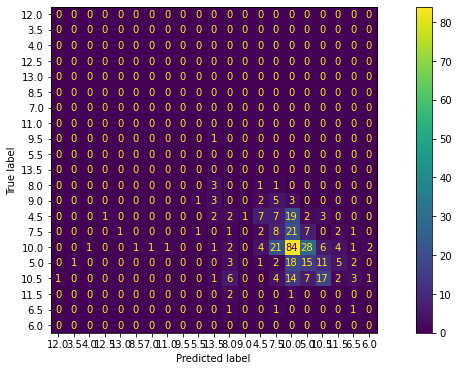

In [37]:
from evaluation import eval_clf, half_round, eval_regr, eval_all
eval_all(y_test, y_pred, 'ARIMA')

In [41]:
y_test

,next_mood
32,7.6
33,7.4
34,7.6
35,7.6
36,7.2
...,...
1236,6.2
1237,8.2
1238,7.0
1239,6.8


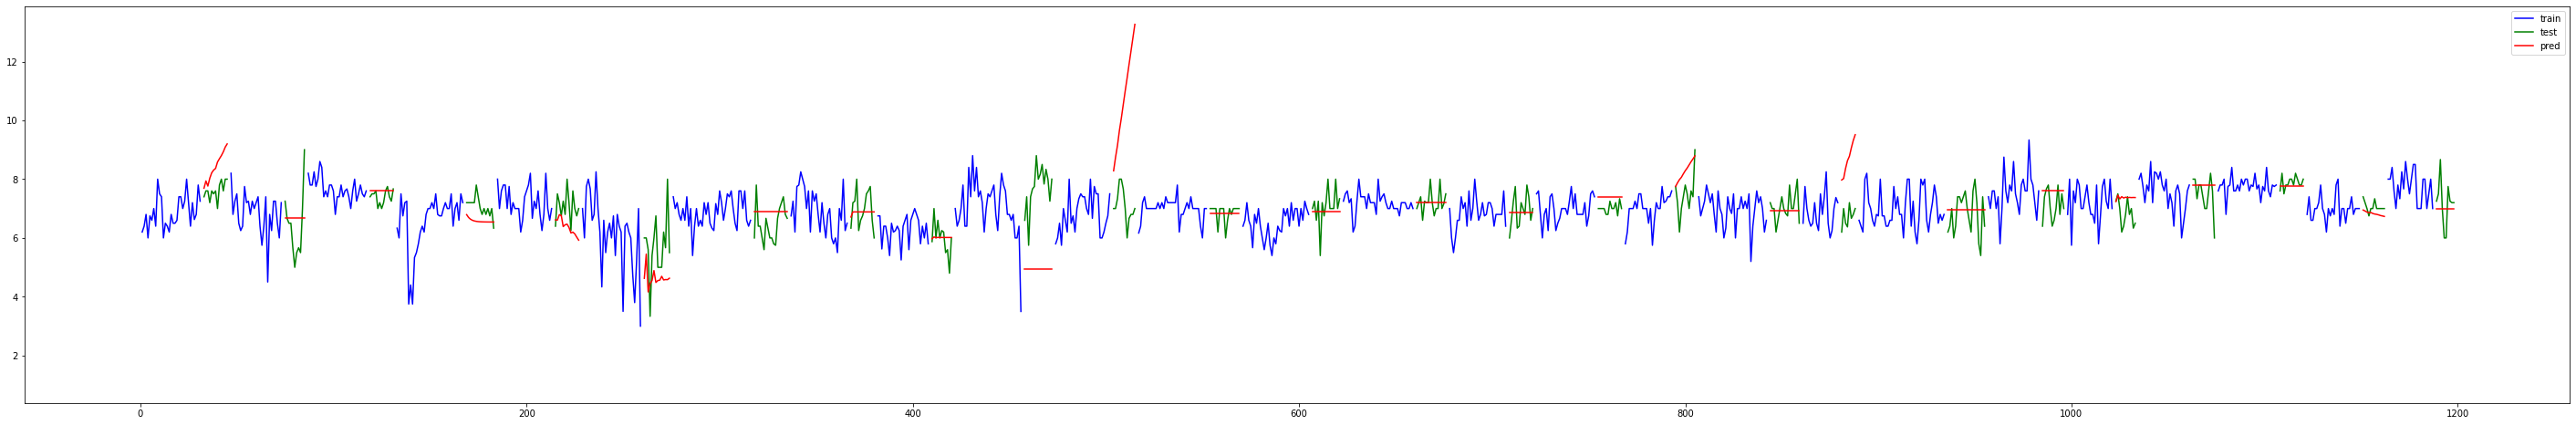

In [42]:
current_series_y = []
current_series_index = []
fig,ax = plt.subplots(figsize=(50,8))

i_prev = y_train.reset_index().iloc[0,:]['index']
for _,row in y_train.reset_index().iterrows():
    if row['index'] != i_prev + 1:
        ax.plot(current_series_index, current_series_y, c='b')
        current_series_y = []
        current_series_index = []
    else: 
        current_series_y.append(row['next_mood'])
        current_series_index.append(row['index'])
    i_prev = row['index']

current_series_y = []
current_series_index = []
i_prev = y_test.reset_index().iloc[0,:]['index']
for _,row in y_test.reset_index().iterrows():
    if row['index'] != i_prev + 1:
        ax.plot(current_series_index, current_series_y, c='g')
        current_series_y = []
        current_series_index = []
    else: 
        current_series_y.append(row['next_mood'])
        current_series_index.append(row['index'])
    i_prev = row['index']

current_series_y = []
current_series_index = []
y_pred_rescaled = pd.concat([pd.DataFrame(y_test.index, columns=['index']), y_pred], axis=1).set_index('index')
i_prev = y_pred_rescaled.reset_index().iloc[0,:]['index']
for _,row in y_pred_rescaled.reset_index().iterrows():
    if row['index'] != i_prev + 1:
        ax.plot(current_series_index, current_series_y, c='r')
        current_series_y = []
        current_series_index = []
    else: 
        current_series_y.append(row[0])
        current_series_index.append(row['index'])
    i_prev = row['index']

l_train, = plt.plot([1], c='b')
l_test, = plt.plot([1], c='g')
l_pred, = plt.plot([1], c='r')



plt.legend([l_train, l_test, l_pred],['train', 'test', 'pred']);